Install packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor



2. Factor analysis

 2.1.Load the 15 subscales you specified.  
 2.2.Clean & z-score subscales so EFA runs on the correlation matrix.  
 2.3 Factorability: Bartlett (want p<.05) and KMO (>.60 ok, >.80 great).  
 2.4 Pick #factors with scree + parallel analysis (keeps only eigenvalues bigger than the 95th percentile of random).  
 2.5 EFA using maximum likelihood + oblimin (factors allowed to correlate).  
 2.6 Paper-style bar plot: contiguous bars, one color per questionnaire (BFI, IUS, NFC, IRI, PANAS, SVS), zero line, compact legend.  
 2.7 Factor scores (z) for each participant saved to factor_scores_15subscales.csv.  
 2.8 Belief change: uses Belief_Change, or computes Post − Pre if both exist.  2.9 Regression: Belief_Change ~ Factors (+ optional age/gender/education), prints full OLS table, draws coefficient CIs, and VIFs.




In [3]:
# ===============================================
# EFA on 15 subscales + plots + OLS
# ===============================================


# ---------------------------
# CONFIG — update path ONLY
# ---------------------------
'''
CSV_PATH = "ffinal_allsubj_personality_coded.xlsx"   # <-- your CSV file here
ID_COL   = None                          # or "Subject_ID" if present
MAX_MISSING_ROW_FRAC = 0.2               # drop rows with >20% missing subscales
RANDOM_STATE = 42
PARALLEL_N_ITER = 500                    # more iters = smoother parallel analysis

np.random.seed(RANDOM_STATE)

# ------------------------------------
# 1) Load CSV and select these columns
# ------------------------------------
cols_expected = [
    "BFI_O","BFI_C","BFI_E","BFI_A","BFI_N",
    "IUS_Total","NFC_Total",
    "IRI_PT","IRI_FS","IRI_EC","IRI_PD",
    "PANAS_PA","PANAS_NA",
    "SVS_Openness","SVS_Conservation"
]
df_excel = pd.read_excel(CSV_PATH, sheet_name = None)
df_excel = pd.concat(df_excel.values(), ignore_index=True)
df_excel.to_csv("df_raw", index = None)
df_raw = pd.read_csv("df_raw") #converts xlsx to csv

missing = [c for c in cols_expected if c not in df_raw.columns]
if missing:
    raise ValueError(f"Missing expected columns in CSV: {missing}")

subs = df_raw[cols_expected].copy()
subs.head()
'''

'\nCSV_PATH = "ffinal_allsubj_personality_coded.xlsx"   # <-- your CSV file here\nID_COL   = None                          # or "Subject_ID" if present\nMAX_MISSING_ROW_FRAC = 0.2               # drop rows with >20% missing subscales\nRANDOM_STATE = 42\nPARALLEL_N_ITER = 500                    # more iters = smoother parallel analysis\n\nnp.random.seed(RANDOM_STATE)\n\n# ------------------------------------\n# 1) Load CSV and select these columns\n# ------------------------------------\ncols_expected = [\n    "BFI_O","BFI_C","BFI_E","BFI_A","BFI_N",\n    "IUS_Total","NFC_Total",\n    "IRI_PT","IRI_FS","IRI_EC","IRI_PD",\n    "PANAS_PA","PANAS_NA",\n    "SVS_Openness","SVS_Conservation"\n]\ndf_excel = pd.read_excel(CSV_PATH, sheet_name = None)\ndf_excel = pd.concat(df_excel.values(), ignore_index=True)\ndf_excel.to_csv("df_raw", index = None)\ndf_raw = pd.read_csv("df_raw") #converts xlsx to csv\n\nmissing = [c for c in cols_expected if c not in df_raw.columns]\nif missing:\n    raise V

In [4]:
# ===============================================
# EFA on 15 subscales + plots + OLS
# ===============================================


# ---------------------------
# CONFIG — update path ONLY
# ---------------------------
CSV_PATH = "final_final_allsubj_personality_coded.xlsx"   # <-- your CSV file here
ID_COL   = None                          # or "Subject_ID" if present
MAX_MISSING_ROW_FRAC = 0.2               # drop rows with >20% missing subscales
RANDOM_STATE = 42
PARALLEL_N_ITER = 500                    # more iters = smoother parallel analysis

np.random.seed(RANDOM_STATE)

# ------------------------------------
# 1) Load CSV and select these columns
# ------------------------------------
cols_expected = [
    "BFI_O","BFI_C","BFI_E","BFI_A","BFI_N",
    "IUS_Total","NFC_Total",
    "IRI_PT","IRI_FS","IRI_EC","IRI_PD",
    "PANAS_PA","PANAS_NA",
    "SVS_Openness","SVS_Conservation",
]
df_sheets = pd.read_excel(CSV_PATH, sheet_name = None)
merged_df = None
for name, df in df_sheets.items():
    df = df.copy()
    df["SheetName"] = name  # optional, keep track of sheet origin
    if merged_df is None:
        merged_df = df
    else:
        # Merge on 'ID', keep all IDs (outer join)
        merged_df = pd.merge(merged_df, df, on="sub#", how="outer", suffixes=('', f'_{name}'))

merged_df.to_csv("df_raw.csv", index = False)
df_raw = pd.read_csv("df_raw.csv") #converts xlsx to csv
print("Columns in df_raw:", df_raw.columns.tolist())

missing = [c for c in cols_expected if c not in df_raw.columns]
if missing:
    raise ValueError(f"Missing expected columns in CSV: {missing}")

subs = df_raw[cols_expected].copy()
subs.head()


Columns in df_raw: ['sub#', 'A1.我想我自己是健談的', 'A2.我想我自己是傾向挑人毛病', 'A3. 我想我自己是會貫徹始終把事情做完', 'A4.我想我自己是憂鬱的', 'A5.我想我自己是會創新、有新想法', 'A6.我想我自己是沉默寡言', 'A7.我想我自己是樂於助人且無私的', 'A8.我想我自己是有點粗心', 'A9.我想我自己是放鬆的，善於處理壓力', 'A10.我想我自己是會對許多不同事物感到好奇', 'A11.我想我自己是充滿活力', 'A12.我想我自己是會開啟與他人的爭執', 'A13.我想我自己是可信賴的工作者', 'A14.我想我自己是緊張的', 'A15.我想我自己是聰明的、會深思的人', 'A16.我想我自己是有非常多熱情', 'A17.我想我自己是有寬容本質', 'A18.我想我自己是較沒有條理組織的', 'A19.我想我自己是擔心很多的', 'A20.我想我自己是具有生動想像力', 'A21.我想我自己是較安靜的', 'A22.我想我自己是通常容易信賴他人', 'A23.我想我自己是較懶散的', 'A24.我想我自己是情緒上穩定、不容易煩躁', 'A25.我想我自己是有創造力的', 'A26.我想我自己是有果決個性的', 'A27.我想我自己是對他人冷漠及疏離的', 'A28.我想我自己是會堅持到工作完成', 'A29.我想我自己是情緒不穩定的', 'A30.我想我自己是重視藝術及美學經驗', 'A31.我想我自己是有時會害羞、退縮的', 'A32.我想我自己是幾乎對所有人體貼且仁慈的', 'A33.我想我自己是做事有效率的', 'A34.我想我自己是在緊張情境也能保持冷靜', 'A35.我想我自己是偏好例行性工作', 'A36.我想我自己是喜歡外出、好社交的', 'A37.我想我自己是有時會粗魯對待他人', 'A38.我想我自己是會訂計畫並依計畫執行', 'A39.我想我自己是容易感到緊張的', 'A40.我想我自己是喜歡思考、常有想法', 'A41.我想我自己是對於藝術興趣很低', 'A42.我想我自己是喜歡與他人合作', 'A43.我想我自己是易於分心的', 'A44.我想我自己是懂得藝術、音樂和文學', 'BFI_O', 'BFI_C', 'BFI_E', 'BFI_A', 'BFI_N',

,BFI_O,BFI_C,BFI_E,BFI_A,BFI_N,IUS_Total,NFC_Total,IRI_PT,IRI_FS,IRI_EC,IRI_PD,PANAS_PA,PANAS_NA,SVS_Openness,SVS_Conservation
0,4.375,3.352941,2.9375,3.588235,3.615385,2.083333,3.600000,3.666667,3.714286,3.571429,3.000000,2.928571,2.9,6.0,2.666667
1,4.625,3.411765,3.1875,3.235294,3.384615,3.500000,2.933333,3.333333,3.500000,3.714286,3.714286,2.500000,2.7,6.5,7.000000
2,3.125,3.941176,3.6875,3.588235,3.846154,3.250000,3.800000,4.000000,3.857143,4.142857,3.714286,3.214286,2.8,6.0,4.666667
3,2.250,3.117647,3.3125,3.294118,2.846154,3.333333,4.533333,2.666667,3.214286,3.285714,3.428571,2.285714,2.5,3.0,4.333333
4,2.500,2.470588,3.1875,2.470588,2.461538,3.916667,4.400000,2.333333,3.428571,3.000000,3.428571,3.428571,2.5,6.0,5.666667


In [5]:
CSV_PATH_2 = "allsubj_personality(2).xlsx"
worksheet = pd.read_excel(CSV_PATH_2, sheet_name= '工作表1')
opposing_update_one = worksheet.loc[0:44, '1stUpdated']
opposing_update_two = worksheet.loc[45:86, '2ndUpdate']
opposing_update = pd.concat([opposing_update_one, opposing_update_two], ignore_index=True)
supporting_update_one = worksheet.loc[0:44, '2ndUpdate']
supporting_update_two = worksheet.loc[45:86, '1stUpdated']
supporting_update = pd.concat([supporting_update_one, supporting_update_two], ignore_index=True)
opposing_update = pd.Series(opposing_update)
supporting_update = pd.Series(supporting_update)
                            



Bartlett’s χ²=576.2, p=3.81e-66 (want p<.05)
KMO overall=0.691 (>.60 acceptable; >.80 great)


c:\Users\27KarlC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


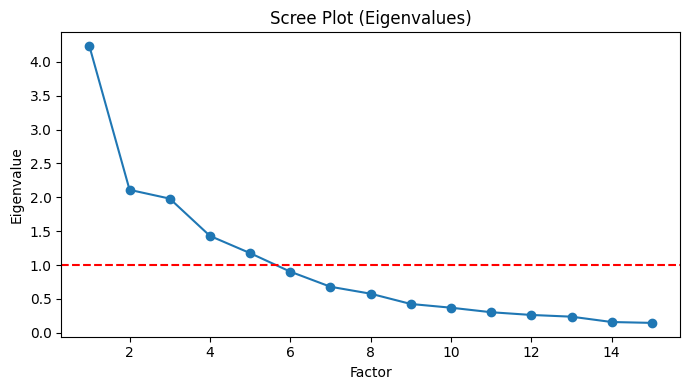

Parallel analysis suggests 4 factors; Kaiser>1 suggests 5. → Using n_factors=4


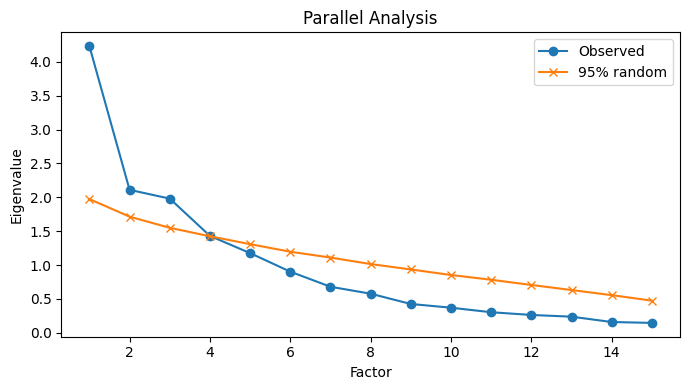

c:\Users\27KarlC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\27KarlC\AppData\Local\Temp\ipykernel_24436\2408798086.py:108: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  order_first = df.groupby('group').apply(lambda g: cols_expected.index(g['var'].iloc[0]) if g['var'].iloc[0] in cols_expected else 999)


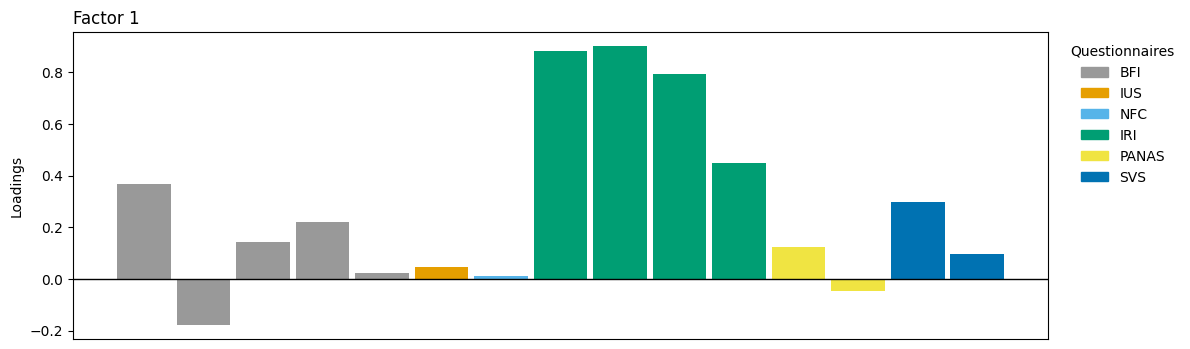

Saved factor scores → factor_scores_15subscales.csv


c:\Users\27KarlC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,sub#,A1.我想我自己是健談的,A2.我想我自己是傾向挑人毛病,A3. 我想我自己是會貫徹始終把事情做完,A4.我想我自己是憂鬱的,A5.我想我自己是會創新、有新想法,A6.我想我自己是沉默寡言,A7.我想我自己是樂於助人且無私的,A8.我想我自己是有點粗心,A9.我想我自己是放鬆的，善於處理壓力,...,F7.仁慈 (樂於助人、誠實、寬恕、忠誠、責任),F8.傳統 (尊重傳統、謙遜、接受命運、奉獻、謙虛),F9.遵從 (服從、孝敬父母和長輩、自律、禮貌),F10.安全 (國家安全、家庭安全、社會秩序、潔淨、互利互惠),SVS_Openness,SVS_Conservation,Belief_Change,Belief_Pre,Belief_Post,SheetName_6-Short Schwartz's Value Survey
0,sub-01,3,4,4,2,4,2,4,2,4,...,7,1,2,5,6.0,2.666667,0,0,0,6-Short Schwartz's Value Survey
1,sub-02,2,3,4,3,5,3,2,2,3,...,7,7,7,7,6.5,7.000000,0,0,0,6-Short Schwartz's Value Survey
2,sub-03,4,2,5,2,2,3,4,4,3,...,7,3,5,6,6.0,4.666667,0,0,0,6-Short Schwartz's Value Survey
3,sub-04,3,4,4,2,1,3,5,4,4,...,7,2,5,6,3.0,4.333333,0,0,0,6-Short Schwartz's Value Survey
4,sub-05,3,2,4,3,2,4,2,2,5,...,5,6,6,5,6.0,5.666667,0,0,0,6-Short Schwartz's Value Survey


In [6]:


# ------------------------------------
# 2) Missing data handling & z-scoring
# ------------------------------------
row_missing = subs.isna().mean(axis=1)
keep = row_missing <= MAX_MISSING_ROW_FRAC
if (~keep).sum():
    print(f"Dropping {(~keep).sum()} rows (> {int(MAX_MISSING_ROW_FRAC*100)}% missing subscales)")
subs = subs.loc[keep].copy()

# mean-impute then z-score
subs = subs.apply(lambda s: s.fillna(s.mean()), axis=0)
subs_z = (subs - subs.mean()) / subs.std(ddof=0)


# ------------------------------------------------
# 3) Factorability checks: Bartlett & KMO (sanity)
#------------------------------------------------

bart_chi2, bart_p = calculate_bartlett_sphericity(subs_z)
kmo_per_item, kmo_overall = calculate_kmo(subs_z)
print(f"Bartlett’s χ²={bart_chi2:.1f}, p={bart_p:.3g} (want p<.05)")
print(f"KMO overall={kmo_overall:.3f} (>.60 acceptable; >.80 great)")

# ------------------------------------------------
# 4) Choose number of factors: Scree + Parallel
# ------------------------------------------------
fa_tmp = FactorAnalyzer(rotation=None, method="ml")
fa_tmp.fit(subs_z)
ev, _ = fa_tmp.get_eigenvalues()

plt.figure(figsize=(7,4))
plt.plot(range(1, len(ev)+1), ev, marker='o')
plt.axhline(1, color='r', ls='--')
plt.title("Scree Plot (Eigenvalues)")
plt.xlabel("Factor")
plt.ylabel("Eigenvalue")
plt.tight_layout()
plt.show()

def parallel_analysis_eigs(df, n_iter=500, random_state=42):
    rng = np.random.default_rng(random_state)
    n, p = df.shape
    obs_corr = np.corrcoef(df, rowvar=False)
    obs_eigs = np.linalg.eigvalsh(obs_corr)[::-1]
    rand_eigs = []
    for _ in range(n_iter):
        rand = rng.standard_normal(size=(n, p))
        rand_corr = np.corrcoef(rand, rowvar=False)
        rand_eigs.append(np.linalg.eigvalsh(rand_corr)[::-1])
    rand_eigs = np.vstack(rand_eigs)
    perc95 = np.percentile(rand_eigs, 95, axis=0)
    return obs_eigs, perc95

obs_eigs, perc95 = parallel_analysis_eigs(subs_z, n_iter=PARALLEL_N_ITER, random_state=RANDOM_STATE)
n_pa = int((obs_eigs > perc95).sum())
n_kaiser = int((obs_eigs > 1.0).sum())
n_factors = n_pa if n_pa > 0 else max(1, n_kaiser)
print(f"Parallel analysis suggests {n_pa} factors; Kaiser>1 suggests {n_kaiser}. → Using n_factors={n_factors}")

plt.figure(figsize=(7,4))
plt.plot(range(1, len(obs_eigs)+1), obs_eigs, marker='o', label='Observed')
plt.plot(range(1, len(perc95)+1), perc95, marker='x', label='95% random')
plt.title("Parallel Analysis")
plt.xlabel("Factor")
plt.ylabel("Eigenvalue")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------
# 5) EFA (ML + oblimin) on these 15 vars
# ---------------------------------------
fa = FactorAnalyzer(n_factors=n_factors, rotation="oblimin", method="ml")
fa.fit(subs_z)

loadings = pd.DataFrame(
    fa.loadings_, index=subs_z.columns,
    columns=[f"Factor{i+1}" for i in range(n_factors)]
)

# --------------------------------------------------------------
# 6) Paper-style grouped bar plot for any factor (like the paper)
# --------------------------------------------------------------
def which_group(var):
    if var.startswith("BFI_"):   return "BFI"
    if var.startswith("IUS_"):   return "IUS"
    if var.startswith("NFC_"):   return "NFC"
    if var.startswith("IRI_"):   return "IRI"
    if var.startswith("PANAS_"): return "PANAS"
    if var.startswith("SVS_"):   return "SVS"
    return "Other"

palette = {
    'BFI':'#999999',   # gray
    'IUS':'#E69F00',   # orange
    'NFC':'#56B4E9',   # blue
    'IRI':'#009E73',   # green
    'PANAS':'#F0E442', # yellow
    'SVS':'#0072B2',   # dark blue
    'Other':'#CC79A7'  # magenta
}

def plot_factor_bar(loadings_df, factor_name='Factor1', title='Factor 1'):
    df = loadings_df[[factor_name]].copy()
    df['var']   = df.index
    df['group'] = df['var'].map(which_group)
    # group order by first appearance in your column list:
    order_first = df.groupby('group').apply(lambda g: cols_expected.index(g['var'].iloc[0]) if g['var'].iloc[0] in cols_expected else 999)
    group_order = list(order_first.sort_values().index)
    # keep original subscale order within each group (based on cols_expected)
    orig_pos = {v:i for i,v in enumerate(cols_expected)}
    df['orig'] = df['var'].map(orig_pos)
    df['group_cat'] = pd.Categorical(df['group'], categories=group_order, ordered=True)
    df = df.sort_values(['group_cat','orig'])

    x = np.arange(len(df))
    y = df[factor_name].values
    colors = [palette.get(g,'#999999') for g in df['group']]

    plt.figure(figsize=(12, 3.6))
    plt.bar(x, y, color=colors, width=0.9)
    plt.axhline(0, color='black', lw=1)
    plt.ylabel("Loadings")
    plt.title(title, loc='left')
    plt.xticks([], [])  # hide tick labels

    handles = [mpatches.Patch(color=palette[g], label=g) for g in group_order]
    plt.legend(handles=handles, title="Questionnaires",
               bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)
    plt.tight_layout()
    plt.show()

# Example: plot for Factor 1 (rename once you interpret it)
plot_factor_bar(loadings, 'Factor1', title='Factor 1')

# You can also:
# for k in range(n_factors): plot_factor_bar(loadings, f'Factor{k+1}', title=f'Factor {k+1}')
# plot_factor_bar(loadings, 'Factor2', group_map=group_map, group_order=group_order, title='Factor 2: …')
# plot_factor_bar(loadings, 'Factor3', group_map=group_map, group_order=group_order, title='Factor 3: …')

# ---------------------------------------
# 7) Factor scores (z) for each participant
# ---------------------------------------
factor_scores = pd.DataFrame(
    fa.transform(subs_z),
    columns=[f"Factor{i+1}" for i in range(n_factors)],
    index=subs_z.index
)
factor_scores = (factor_scores - factor_scores.mean()) / factor_scores.std(ddof=0)

# optional save
out = factor_scores.copy()
if ID_COL and ID_COL in df_raw.columns:
    out.insert(0, ID_COL, df_raw.loc[subs_z.index, ID_COL].values)
out.to_csv("factor_scores_15subscales.csv", index=False)
print("Saved factor scores → factor_scores_15subscales.csv")

# ----------------------------------------------------
# 8) Outcome: Belief change (existing or pre/post diff)
# ----------------------------------------------------
df_work = df_raw.loc[subs_z.index].copy()
df_work.head()

In [7]:
def first_present(cols, candidates):
    for c in candidates:
        if c in cols: return c
    return None

belief_change_col = first_present(df_work.columns, ["Belief_Change","belief_change","delta_belief"])
belief_change_col = supporting_update + opposing_update
belief_change_col.head() 
print(type(belief_change_col))


<class 'pandas.core.series.Series'>


In [8]:



if belief_change_col is None:
    pre  = first_present(df_work.columns, ["Belief_Pre","belief_pre","pre_belief"])
    post = first_present(df_work.columns, ["Belief_Post","belief_post","post_belief"])

 
    if pre and post:
        df_work["Belief_Change"] = df_work[post] - df_work[pre]
        belief_change_col = "Belief_Change"
        print(f"Computed Belief_Change = {post} - {pre}")
    else:
        raise ValueError("Add a 'Belief_Change' column or both 'Belief_Pre' and 'Belief_Post'.")

design = factor_scores.copy()
design["Belief_Change"] = belief_change_col
#design["Belief_Change"] = df_work[belief_change_col].values

# Auto-add common controls if present
for ctl in ["age","Age","AGE","gender","Gender","education","Education"]:
    if ctl in df_work.columns:
        design[ctl] = df_work[ctl].values

# ----------------------------------------
# 9) OLS: Belief_Change ~ latent factors (+ controls)
# ----------------------------------------
factor_cols = [c for c in design.columns if c.startswith("Factor")]
controls = [c for c in ["age","Age","AGE","gender","Gender","education","Education"] if c in design.columns]
rhs = " + ".join(factor_cols + controls) if controls else " + ".join(factor_cols)
formula = f"Belief_Change ~ {rhs}"
print("OLS formula:", formula)

ols = smf.ols(formula, data=design.dropna(subset=["Belief_Change"])).fit()
print(ols.summary())

# coef plot (factors only)
coefs = ols.params.loc[factor_cols]



OLS formula: Belief_Change ~ Factor1 + Factor2 + Factor3 + Factor4
                            OLS Regression Results                            
Dep. Variable:          Belief_Change   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.433
Date:                Sat, 06 Sep 2025   Prob (F-statistic):              0.230
Time:                        21:44:51   Log-Likelihood:                -239.73
No. Observations:                  87   AIC:                             489.5
Df Residuals:                      82   BIC:                             501.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

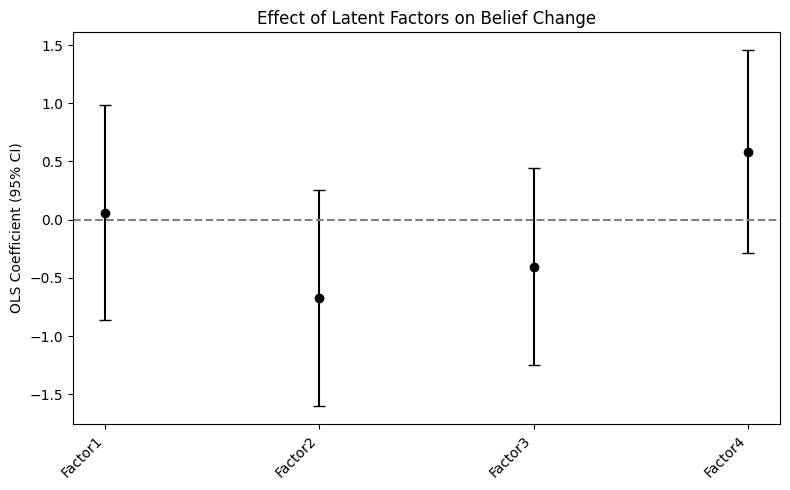

In [9]:
#plot for coef plot

coefs = ols.params.loc[factor_cols]
conf = ols.conf_int().loc[factor_cols]
conf.columns = ["lower", "upper"]

# build plot
plt.figure(figsize=(8, 5))
plt.errorbar(
    coefs.index, coefs.values,
    yerr=[coefs.values - conf["lower"], conf["upper"] - coefs.values],
    fmt="o", capsize=4, color="black"
)

# add a zero line for reference
plt.axhline(0, color="gray", linestyle="--")

# prettify labels
plt.xticks(rotation=45, ha="right")
plt.ylabel("OLS Coefficient (95% CI)")
plt.title("Effect of Latent Factors on Belief Change")

plt.tight_layout()
plt.show()